In [1]:
!pip install nltk



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import ast
import re
import pandas as pd
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mitta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mitta\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mitta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mitta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
train_path = "dataset\TRAIN.csv"
test_path = "dataset\TEST.csv"
lemmatizer = WordNetLemmatizer()
train_data = pd.read_csv(train_path, header=None, names=['sentence'])
test_data = pd.read_csv(test_path, header=None, names=['sentence'])

def get_synonym(word):
    synonyms = wordnet.synsets(word)
    if synonyms:
        return synonyms[0].lemmas()[0].name()  # Return first synonym
    return word

def augment_text(text):
    """Create both original and synonym-replaced versions of the sentence."""
    if not isinstance(text, str):
        return []
    
    try:
        words_with_tags = ast.literal_eval(text)
        if not isinstance(words_with_tags, list):
            return []
    except (SyntaxError, ValueError):
        return []
    
    # Original sentence
    original = [(lemmatizer.lemmatize(str(word).lower()), str(tag)) for word, tag in words_with_tags]
    
    # Augmented sentence with synonyms
    augmented = [(get_synonym(word), tag) for word, tag in original]
    
    return [original, augmented]  # Return both versions

# Apply preprocessing to dataset with augmentation
augmented_sentences = train_data['sentence'].apply(augment_text)

# Flatten the list so both original & augmented sentences are added
train_data = pd.DataFrame({'sentence': [sent for pair in augmented_sentences for sent in pair]})

test_data['sentence'] = test_data['sentence'].apply(lambda x: [(lemmatizer.lemmatize(str(word).lower()), str(tag)) for word, tag in ast.literal_eval(x)] if isinstance(x, str) else [])



In [4]:
import ast
import re

patterns = {
    "Date": r"\b\d{2}/\d{2}/\d{4}\b",
    "Time": r"\b\d{1,2}:\d{2}\b",
    "Decimal": r"\b\d+\.\d+\b",
    "Integer": r"\b\d+\b",
    "Fraction": r"\b\d+/\d+\b",
}


def process_sentences(df):
    df["sentence"] = df["sentence"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    for sequence in df["sentence"]:
        for i in range(len(sequence) - 1, -1, -1):
            word = sequence[i][0]
            pos = sequence[i][1]
            if pos in ["CCONJ"]:
                pos = "CONJ"
            if pos == "AUX":
                pos = "VERB"
            if pos in [".", "PUNCT"]:
                pos = "PUNCT"
            if pos in ["ADP"]:
                pos = "ADV"
            if pos in ["SYM", "INTJ", "_"]:
                pos = "X"

            for category, pattern in patterns.items():
                if re.match(pattern, word):
                    pos = "NUM"
                    break
            
            sequence[i] = (word, pos)
    return df

train_data = process_sentences(train_data)
test_data = process_sentences(test_data)

In [5]:
words = set(word for sentence in train_data['sentence'] for word, _ in sentence)
tags = set(tag for sentence in train_data['sentence'] for _, tag in sentence)
print(tags)

transition_counts = defaultdict(lambda: defaultdict(int))
emission_counts = defaultdict(lambda: defaultdict(int))
initial_counts = defaultdict(int)

{'ADV', 'CONJ', 'ADJ', 'DET', 'PART', 'NOUN', 'PRON', 'PROPN', 'PUNCT', 'X', 'VERB', 'PRT', 'NUM', 'SCONJ'}


In [6]:
def train_hmm(train_data):
    for sentence in train_data['sentence']:
        prev_tag = None
        for word, tag in sentence:
            emission_counts[tag][word] += 1
            if prev_tag is not None:
                transition_counts[prev_tag][tag] += 1
            else:
                initial_counts[tag] += 1
            prev_tag = tag


In [7]:
def normalize_counts(counts):
    probabilities = {}
    for key, sub_counts in counts.items():
        total = sum(sub_counts.values())
        probabilities[key] = {k: v / total for k, v in sub_counts.items()}
    return probabilities

In [8]:
train_hmm(train_data)
transition_probs = normalize_counts(transition_counts)
emission_probs = normalize_counts(emission_counts)
initial_probs = {k: v / sum(initial_counts.values()) for k, v in initial_counts.items()}


In [9]:
def viterbi(words, transition_probs, emission_probs, initial_probs, tags):
    V = [{}]
    backpointer = [{}]
    
    for tag in tags:
        V[0][tag] = initial_probs.get(tag, 0) * emission_probs[tag].get(words[0], 0)
        backpointer[0][tag] = None
    
    for t in range(1, len(words)):
        V.append({})
        backpointer.append({})
        for tag in tags:
            max_prob, best_prev_tag = max(
                (V[t-1][prev_tag] * transition_probs[prev_tag].get(tag, 0) * emission_probs[tag].get(words[t], 0), prev_tag)
                for prev_tag in tags
            )
            V[t][tag] = max_prob
            backpointer[t][tag] = best_prev_tag
    
    best_last_tag = max(V[-1], key=V[-1].get)
    best_path = [best_last_tag]
    for t in range(len(words) - 1, 0, -1):
        best_path.insert(0, backpointer[t][best_path[0]])
    
    return best_path

In [10]:
def evaluate(test_data):
    correct, total = 0, 0
    for sentence in test_data['sentence']:
        words = [word for word,_ in sentence]
        actual_tags = [tag for _, tag in sentence]
        predicted_tags = viterbi(words, transition_probs, emission_probs, initial_probs, tags)
        correct += sum(p == a for p, a in zip(predicted_tags, actual_tags))
        total += len(actual_tags)
    accuracy = correct / total if total > 0 else 0
    print("Model Accuracy: "+str(accuracy*100)+"%")

evaluate(test_data)


Model Accuracy: 88.52689660403117%


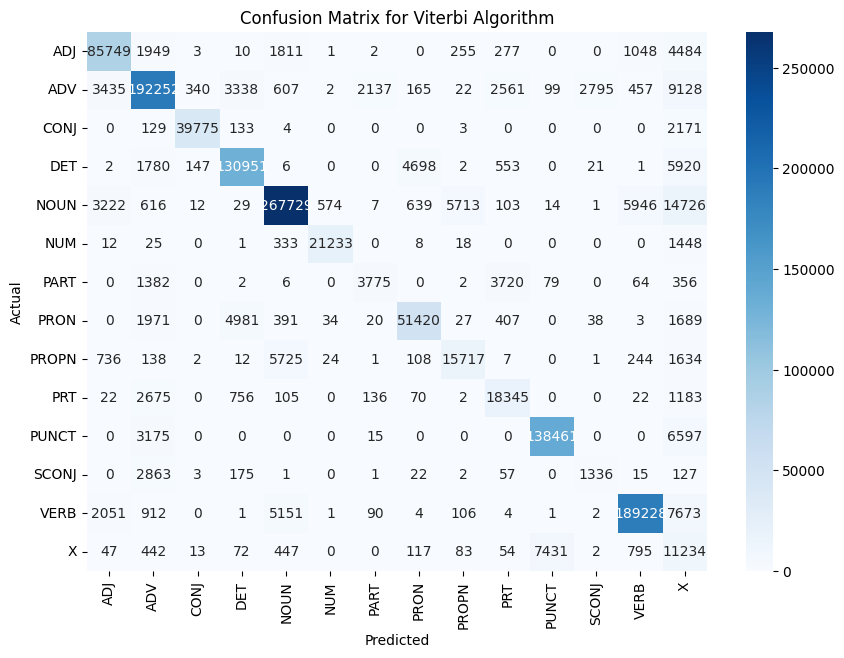

Model Accuracy: 88.53%


In [11]:
def evaluate_with_confusion_matrix(test_data):
    actual_tags_list = []
    predicted_tags_list = []
    
    for sentence in test_data['sentence']:
        words = [word for word, _ in sentence]
        actual_tags = [tag for _, tag in sentence]
        predicted_tags = viterbi(words, transition_probs, emission_probs, initial_probs, tags)
        
        actual_tags_list.extend(actual_tags)
        predicted_tags_list.extend(predicted_tags)

    # Compute confusion matrix
    tag_labels = sorted(set(actual_tags_list + predicted_tags_list))  # Unique tags
    cm = confusion_matrix(actual_tags_list, predicted_tags_list, labels=tag_labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=tag_labels, yticklabels=tag_labels, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for Viterbi Algorithm")
    plt.show()

    # Print accuracy
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    print(f"Model Accuracy: {accuracy * 100:.2f}%")

evaluate_with_confusion_matrix(test_data)